In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, execute
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt





import numpy as np

In [2]:
# Setup

M = 2  #Number of Localizations
N = 2*M #total number of operators (Two positions times two spin polarizations)

zero = Operator(np.zeros((2**N,2**N)))


In [3]:
# Define a basis for four level system (two positions times two spin polarizations)

Tu_circ = QuantumCircuit(N)
Tu_circ.x(0)
Tu = Statevector(Tu_circ)

Td_circ = QuantumCircuit(N)
Td_circ.x(1)
Td = Statevector(Td_circ)

Bu_circ = QuantumCircuit(N)
Bu_circ.x(2)
Bu = Statevector(Bu_circ)

Bd_circ = QuantumCircuit(N)
Bd_circ.x(3)
Bd = Statevector(Bd_circ)

print(Tu)
Tu.draw('latex')
# Tu_circ.draw('mpl')



Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


<IPython.core.display.Latex object>

In [4]:
# Define the Fermionic Operators
op_list = [
    # ({second_q-operator: coefficient}, num_qubits)
    ({"+_0 -_1": 1.0}, 4),  # a^dagger_0 a_1
    ({"+_1 -_0": 1.0}, 4),  # a^dagger_1 a_0
    ({"+_2 -_3": 1.0}, 4),  
    ({"+_3 -_2": 1.0}, 4),  
    ({"+_0 -_0": 1.0}, 4),  
    ({"+_1 -_1": 1.0}, 4),  
    ({"+_2 -_2": 1.0}, 4),  
    ({"+_3 -_3": 1.0}, 4),  
    ({"+_0 -_2": 1.0}, 4),  
    ({"+_1 -_3": 1.0}, 4),  
    ({"+_2 -_0": 1.0}, 4),  
    ({"+_3 -_1": 1.0}, 4),  
    
]



op_list_TLS = [
    ({"+_0 -_1": 1.0}, 2),  # a^dagger_0 a_1
    ({"+_1 -_0": 1.0}, 2),
    ({"+_0 -_0": 1.0}, 2),
    ({"+_1 -_1": 1.0}, 2)
]

In [5]:
op_list[0][1]


4

In [6]:
class FermionicOperator():

    def __init__(self, op_list: list | np.ndarray, num_qubits: int=None):
        self.op_list = op_list
        self.num_qubits = num_qubits

        self.ops_split = []

        max_idx = 0
        for op, coeff in self.op_list.items():
            op_split = op.split()
            num_ops = len(op_split)
            self.ops_split.append({
                "indices": [int(o[-1]) for o in op_split],
                "conjugation": [o[0] for o in op_split],
                "coeff": coeff
            })

            if max_idx < max(self.ops_split[-1]["indices"]):
                max_idx = max(self.ops_split[-1]["indices"])

            if num_ops % 2 != 0 or self.ops_split[-1]["conjugation"].count("+") != num_ops / 2:
                raise ValueError(f"FermionicOperator.map_operator(): {op} invalid")

        if self.num_qubits is None:
            self.num_qubits = max_idx + 1
        elif self.num_qubits < max_idx + 1:
            raise ValueError(f"FermionicOperator.__init__(): num_qubits ({self.num_qubits}) is smaller than maximum operator index")

    def map_operator(self):
        mapped_op_list = []
        for i, op in enumerate(self.ops_split):
            if len(op["indices"]) == 2 and op["indices"][0] == op["indices"][1]:
                mapped_op_list.append(self._map_number_op(op))
            elif len(op["indices"]) == 2 and op["indices"][0] != op["indices"][1]:
                mapped_op_list.append(self._map_two_body_hop_op(op))
            
        return mapped_op_list

    def _map_number_op(self, op):
        # p:
        # (X - iY)_p (X + iY)_p

        mapped_op = []
        norm = 1./2

        idx = op["indices"][0]

        mapped_op.append((
            (self.num_qubits - idx - 1) * "I" + "I" + idx * "I",
            op["coeff"] * norm
        ))

        mapped_op.append((
            (self.num_qubits - idx - 1) * "I" + "Z" + idx * "I",
            -op["coeff"] * norm
        ))

        return SparsePauliOp.from_list(mapped_op)
    
    def _map_two_body_hop_op(self, op):
        

        mapped_op = []
        norm = 1./4

        idx0 = op["indices"][0]
        idx1 = op["indices"][1]

        if op["conjugation"][0] == "+":

            if idx0 > idx1:

                # p > q:
                # (X - iY)_p Z_p-1 ... Z_q+1 (X + iY)_q

                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "X" + (idx0 - idx1 - 1) * "Z" + "X" + idx1 * "I",
                    op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "Y" + (idx0 - idx1 - 1) * "Z" + "X" + idx1 * "I",
                    - 1.j * op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "X" + (idx0 - idx1 - 1) * "Z" + "Y" + idx1 * "I",
                    1.j * op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "Y" + (idx0 - idx1 - 1) * "Z" + "Y" + idx1 * "I",
                    op["coeff"] * norm
                ))

            elif idx0 < idx1:

                # p < q:
                # (X - iY)_p (X + iY)_q Z_q-1 ... Z_p

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "X" + (idx1 - idx0 - 1) * "Z" + "Y" + idx0 * "I",
                    -1.j * op["coeff"] * norm
                ))

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "Y" + (idx1 - idx0 - 1) * "Z" + "Y" + idx0 * "I",
                    op["coeff"] * norm
                ))

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "X" + (idx1 - idx0 - 1) * "Z" + "X" + idx0 * "I",
                    op["coeff"] * norm
                ))

                mapped_op.append((          
                    (self.num_qubits - idx1 - 1) * "I" + "Y" + (idx1 - idx0 - 1) * "Z" + "X" + idx0 * "I",
                    + 1.j * op["coeff"] * norm
                ))

                

                      

                
        elif op["conjugation"][0] == "-":


            if idx0 > idx1:

                # p > q:
                # (X + iY)_p Z_p-1 ... Z_q+1 (X - iY)_q

                
                
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "X" + (idx0 - idx1 - 1) * "Z" + "Y" + idx1 * "I",
                    + 1.j * op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "X" + (idx0 - idx1 - 1) * "Z" + "X" + idx1 * "I",
                    -op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "Y" + (idx0 - idx1 - 1) * "Z" + "Y" + idx1 * "I",
                    -op["coeff"] * norm
                ))
                mapped_op.append((
                    (self.num_qubits - idx0 - 1) * "I" + "Y" + (idx0 - idx1 - 1) * "Z" + "X" + idx1 * "I",
                    -1.j * op["coeff"] * norm
                ))

            elif idx0 < idx1:

                # p < q:
                # (X + iY)_p (X - iY)_q Z_q-1 ... Z_p

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "X" + (idx1 - idx0 - 1) * "Z" + "Y" + idx0 * "I",
                    -1.j * op["coeff"] * norm
                ))

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "Y" + (idx1 - idx0 - 1) * "Z" + "Y" + idx0 * "I",
                    -op["coeff"] * norm
                ))

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "X" + (idx1 - idx0 - 1) * "Z" + "X" + idx0 * "I",
                    -op["coeff"] * norm
                ))

                mapped_op.append((
                    (self.num_qubits - idx1 - 1) * "I" + "Y" + (idx1 - idx0 - 1) * "Z" + "X" + idx0 * "I",
                    1.j * op["coeff"] * norm
                ))


                



        return SparsePauliOp.from_list(mapped_op)


In [7]:
FermionicOperator(op_list[3][0], N).map_operator()[0]

SparsePauliOp(['XXII', 'YXII', 'XYII', 'YYII'],
              coeffs=[0.25+0.j  , 0.  -0.25j, 0.  +0.25j, 0.25+0.j  ])

In [8]:
# For four level system, hopping from Tu to Td

a = FermionicOperator(op_list[1][0], num_qubits=op_list[1][1])
# print(a.map_operator()[0].to_matrix())

# Apply a to Tu
Tu_a = a.map_operator()[0].to_matrix() @ Tu.data
Tu_a = Statevector(Tu_a)
Tu_a.draw('latex')

# print(Tu_a == Td)



<IPython.core.display.Latex object>

In [9]:
a = FermionicOperator(op_list[1][0], num_qubits=op_list[1][1])
a.map_operator()[0]



SparsePauliOp(['IIXX', 'IIYX', 'IIXY', 'IIYY'],
              coeffs=[0.25+0.j  , 0.  -0.25j, 0.  +0.25j, 0.25+0.j  ])

In [10]:
# Define spin operators
# Notice that spin operators are defined for top and bottom layer
sig_x = [zero, zero]
sig_x[0] = FermionicOperator(op_list[1][0], num_qubits=op_list[1][1]).map_operator()[0] + FermionicOperator(op_list[0][0], num_qubits=op_list[0][1]).map_operator()[0]
sig_x[1] = FermionicOperator(op_list[3][0], num_qubits=op_list[3][1]).map_operator()[0] + FermionicOperator(op_list[2][0], num_qubits=op_list[2][1]).map_operator()[0]

sig_y = [zero, zero]
sig_y[0] = 1j*FermionicOperator(op_list[1][0], num_qubits=op_list[1][1]).map_operator()[0] - 1j*FermionicOperator(op_list[0][0], num_qubits=op_list[0][1]).map_operator()[0]
sig_y[1] = 1j*FermionicOperator(op_list[3][0], num_qubits=op_list[3][1]).map_operator()[0] - 1j*FermionicOperator(op_list[2][0], num_qubits=op_list[2][1]).map_operator()[0]

sig_z = [zero, zero]
sig_z[0] = FermionicOperator(op_list[4][0], num_qubits=op_list[4][1]).map_operator()[0] - FermionicOperator(op_list[5][0], num_qubits=op_list[5][1]).map_operator()[0]
sig_z[1] = FermionicOperator(op_list[6][0], num_qubits=op_list[6][1]).map_operator()[0] - FermionicOperator(op_list[7][0], num_qubits=op_list[7][1]).map_operator()[0]

# Define position operators
# Notice

pos_x = [zero, zero]
pos_x[0] = FermionicOperator(op_list[8][0], num_qubits=op_list[8][1]).map_operator()[0] + FermionicOperator(op_list[10][0], num_qubits=op_list[10][1]).map_operator()[0]
pos_x[1] = FermionicOperator(op_list[11][0], num_qubits=op_list[11][1]).map_operator()[0] + FermionicOperator(op_list[9][0], num_qubits=op_list[9][1]).map_operator()[0]

pos_y = [zero, zero]
pos_y[0] = 1j*FermionicOperator(op_list[8][0], num_qubits=op_list[8][1]).map_operator()[0] - 1j*FermionicOperator(op_list[10][0], num_qubits=op_list[10][1]).map_operator()[0]
pos_y[1] = 1j*FermionicOperator(op_list[11][0], num_qubits=op_list[11][1]).map_operator()[0] - 1j*FermionicOperator(op_list[9][0], num_qubits=op_list[9][1]).map_operator()[0]

pos_z = [zero, zero]
pos_z[0] = FermionicOperator(op_list[4][0], num_qubits=op_list[4][1]).map_operator()[0] - FermionicOperator(op_list[6][0], num_qubits=op_list[6][1]).map_operator()[0]
pos_z[1] = FermionicOperator(op_list[5][0], num_qubits=op_list[5][1]).map_operator()[0] - FermionicOperator(op_list[7][0], num_qubits=op_list[7][1]).map_operator()[0]


In [11]:
Bu.evolve(pos_z[0]).draw('latex')

<IPython.core.display.Latex object>

In [12]:
# # Apply pos_z to Tu
# Tu_pos_z = pos_z[0].to_matrix() @ Tu.data
# Tu_pos_z = Statevector(Tu_pos_z)
# Tu_pos_z.draw('latex')

# Apply pos_z to Bu
Bu_pos_z = pos_z[0].to_matrix() @ Bu.data
Bu_pos_z = Statevector(Bu_pos_z)
Bu_pos_z

Statevector([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,
              0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
              0.+0.j,  0.+0.j],
            dims=(2, 2, 2, 2))


In [13]:
# Define vacuum state
vac = QuantumCircuit(N)
vac = Statevector(vac)
 
# Define basis with labels
Basis=[vac,
       Tu,
       Td,
       Bu,
       Bd]

ket={'00': vac,
     'u0': Tu,
     'd0': Td,
     '0u': Bu,
     '0d': Bd,}



bra={s:ket[s].data.conj().T for s in ket}


def ketbra(state):

    return Statevector(ket[state]).to_operator()



In [14]:
# Define Hamiltonian


E1     = 1         # Energies of the Basis states
E2     = 1.03         
E3     = -E1         
E4     = -E1+.03         
t      = 2       # Tunnelling rate 
SOT    = 3     # SpinOrbit Coupling
SOB    = 0
landau = 2         # g-factor

def H_model(E1=E1,E2=E2,E3=E3,E4=E4,SOT=SOT,SOB=SOB,t=t):
    s  = 0
    s += E1*ketbra('u0')+E2*ketbra('d0')+E3*ketbra('0u')+E4*ketbra('0d')
    s += SOT*ket['u0']@bra['d0']+SOB*ket['0u']@bra['0d']+np.conj(SOB)*ket['0d']@bra['0u']+np.conj(SOT)*ket['d0']@bra['u0']
    s +=  t*(ket['u0']@bra['0u']+ket['d0']@bra['0d'])+np.conj(t)*(ket['0u']@bra['u0']+ket['0d']@bra['d0'])
    return s

In [15]:
Statevector.from_int(3,16).draw('latex')  # maybe useful to define the basis states later

<IPython.core.display.Latex object>

In [16]:
H = H_model()
result = ket['d0'].evolve(H)  # evolve the state
print(result)


Statevector([0.  +0.j, 0.  +0.j, 1.03+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
            dims=(2, 2, 2, 2))


In [17]:
# Define additional Hamiltonian terms

#total spin operators
Sx,Sy,Sz=0,0,0
for i in range(M):
    Sx += sig_x[i]
    Sy += sig_y[i]
    Sz += sig_z[i]


Sx = Sx.simplify()
Sy = Sy.simplify()
Sz = Sz.simplify()

    
#total location pauli operators
Lx,Ly,Lz=0,0,0
for i in range(2):
    Lx += pos_x[i]
    Ly += pos_y[i]
    Lz += pos_z[i]

Lx = Lx.simplify()
Ly = Ly.simplify()
Lz = Lz.simplify()


func = lambda x:x
foo  = type(func)

def H_chargesplit(E):
    if type(E)!=foo:
        return E*Lz
    else:
        return lambda t: E(t)*Lz

def H_spinsplit(E):
    return E*Sz
    
def H_EDSR(alpha,w,t, phi=0):
    # return lambda t: (alpha[0]*sig_x[0]+alpha[1]*sig_x[1])/2*np.cos(w*t+phi) #+detune*Sz
    # return lambda t: (alpha[0]*(sig_x[0]).simplify+alpha[1]*(sig_x[1]).simplify())/2*np.cos(w*t+phi)  # included h.c. to make it hermitian
    return (alpha[0]*sig_x[0].simplify()+alpha[1]*sig_x[1].simplify())/2*np.cos(w*t+phi)
    
def H_LZSI(eps,w,phi=0):
    if type(eps)!=foo:    #if time independent eps is passed as float
        return eps/2*Lx#*np.cos(w*t+phi) #+detune*Lz
    else: #if time dependent eps is passed as a callable
        return lambda t: eps(t)/2*Lx#*np.cos(w*t+phi) #+detune*Lz

In [18]:
alpha = (0.1,1)
(0.1*sig_x[0].simplify()+1*sig_x[1].simplify())

SparsePauliOp(['IIXX', 'IIYY', 'XXII', 'YYII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.5 +0.j, 0.5 +0.j])

In [19]:
type(sig_x[1])

qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp

In [20]:
# complex_pauli_coeff(H_EDSR((0.1, 1),1)(1).simplify())

In [21]:
H_EDSR((0.1, 1),1,1)

SparsePauliOp(['IIXX', 'IIYY', 'XXII', 'YYII'],
              coeffs=[0.01350756+0.j, 0.01350756+0.j, 0.13507558+0.j, 0.13507558+0.j])

In [22]:
sig_x[0]

SparsePauliOp(['IIXX', 'IIYX', 'IIXY', 'IIYY', 'IIXY', 'IIYY', 'IIXX', 'IIYX'],
              coeffs=[0.25+0.j  , 0.  -0.25j, 0.  +0.25j, 0.25+0.j  , 0.  -0.25j, 0.25+0.j  ,
 0.25+0.j  , 0.  +0.25j])

In [23]:
# # Apply Lz to Tu
# Tu_Lz = Lz.to_matrix() @ Tu.data
# Tu_Lz = Statevector(Tu_Lz)
# Tu_Lz.draw('latex')

# Apply Lz to Bu
Bu_Lz = Bu.evolve(Lz)
Bu_Lz = Statevector(Bu_Lz)
Bu_Lz.draw('latex')

<IPython.core.display.Latex object>

In [24]:
# Helper functions

def complex_pauli_coeff(pauli_operator):
    return pauli_operator.coeffs.imag

def is_herm(M):
    h = M.to_matrix()
    return np.allclose(h, h.T.conj())

In [31]:
# Implement time evolution

E_charge=0.001
E_spin  =1

alpha= (0.1,0)
eps  = 0.1

on1=0                       #onset of first drive
T1=2*np.pi/eps*.5           #length of first drive
on2=1                       #wait before of second drive
T2=2*np.pi/.1               #length of second drive
chill=1 

T=on1+T1+on2+T2+chill

w_charge = E_charge*2
w_spin   = E_spin*2

# def H(t):
#     if t<0:
#         return  np.zeros((2**N,2**N))
#     if 0<t<=on1:
#         return  H_spinsplit(E_spin) + H_chargesplit(E_charge)
#     if on1<t<on1+T1:
#         return  H_spinsplit(E_spin) + H_chargesplit(E_charge) + H_LZSI(eps,w_charge)
#     if on1+T1<=t<on1+T1+on2:
#         return  H_spinsplit(E_spin) + H_chargesplit(E_charge)
#     if on1+T1+on2<=t<on1+T1+on2+T2:
#         return  H_spinsplit(E_spin) + H_chargesplit(E_charge) + H_EDSR(alpha,w_spin)(t) 
#     if on1+T1+on2+T2<=t<T:
#         return  H_spinsplit(E_spin) + H_chargesplit(E_charge)
#     if t>=T:
#         return  np.zeros((2**N,2**N))

# Define components of pulsed Hamiltonian
H_0 = H_spinsplit(E_spin) + H_chargesplit(E_charge)
H_charge = H_spinsplit(E_spin) + H_chargesplit(E_charge) + H_LZSI(eps,w_charge)
# def H_spin(t):
#     return H_spinsplit(E_spin) + H_chargesplit(E_charge) + H_EDSR(alpha,w_spin,t)
# H_spin = H_spinsplit(E_spin) + H_chargesplit(E_charge) + H_EDSR(alpha,w_spin)

# # Define the time points
N_steps = 500
tlist = np.linspace(0, T, N_steps)



In [36]:
# Implement time evolution via PauliEvolutionGate
from qiskit.circuit.library import PauliEvolutionGate

state_names=['|T⟩$\otimes$|u⟩','|T⟩$\otimes$|d⟩','|B⟩$\otimes$|u⟩','|B⟩$\otimes$|d⟩']
state_label = ['0001', '0010', '0100', '1000']



# List of time steps
T_start_list = [on1, on1+T1, on1+T1+on2]
T_duration_list = [T1, on2, T2]


# Initialize circuit with Tu statevector

qc = QuantumCircuit(N)
qc.x(0)

psi0 = Statevector(qc)
psi0.draw('latex')

 


<IPython.core.display.Latex object>

Running block 1...


  0%|          | 0/49 [00:00<?, ?it/s]

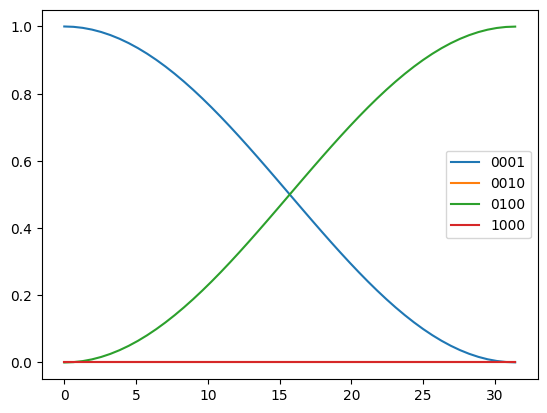

In [37]:
# Evolution block 1

N_steps_block1 = 50
T_block1_list = np.linspace(T_start_list[0], T_start_list[0]+T_duration_list[0], N_steps_block1)
delta_t_block1 = T_block1_list[1]-T_block1_list[0]

# Store states after every time step

states_block1 = []
states_block1.append(psi0)

print('Running block 1...')
for i in tqdm(range(N_steps_block1-1)):
    pauli_gate = PauliEvolutionGate(H_charge, delta_t_block1)
    qc.append(pauli_gate, qc.qubits)
    states_block1.append(Statevector(qc))

circ_block1 = qc.copy()


prob_dict_block1 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block1:
    if len(states.probabilities_dict())==1:
        prob_dict_block1['0001'].append(1)
        prob_dict_block1['0010'].append(0)
        prob_dict_block1['0100'].append(0)
        prob_dict_block1['1000'].append(0)
    else:
        for key in prob_dict_block1.keys():
            prob_dict_block1[key].append(states.probabilities_dict()[key])
    

# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block1_list, prob_dict_block1['0001'], label='0001')
plt.plot(T_block1_list, prob_dict_block1['0010'], label='0010')
plt.plot(T_block1_list, prob_dict_block1['0100'], label='0100')
plt.plot(T_block1_list, prob_dict_block1['1000'], label='1000')
plt.legend()
plt.show()



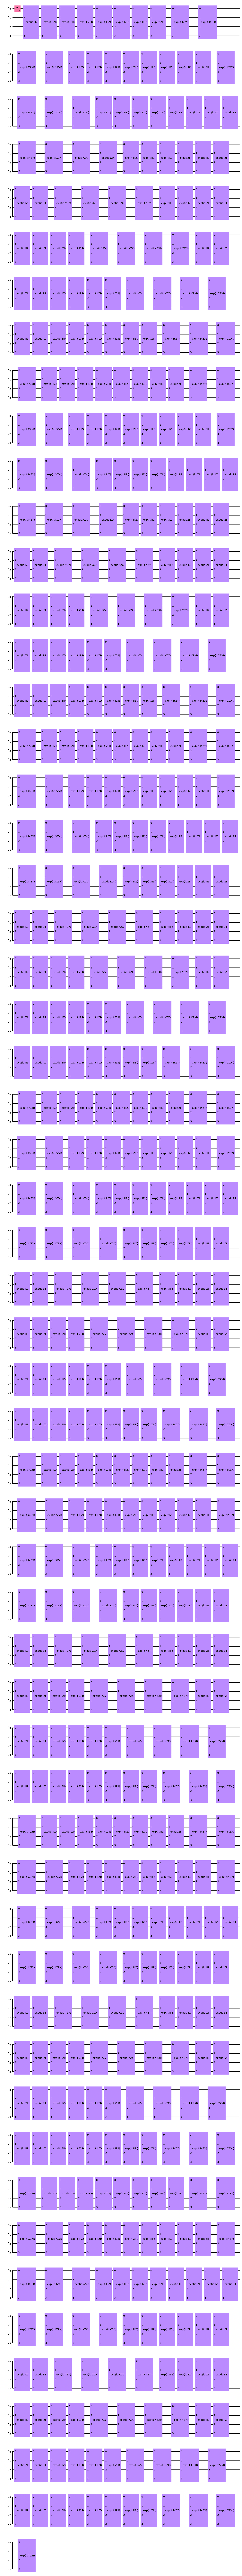

In [40]:
qc.decompose().draw('mpl')

In [56]:
# # Alternative time evolution via TrotterQRTE

# from qiskit_algorithms import TimeEvolutionProblem
# from qiskit_algorithms import TrotterQRTE

# final_time = T1
# initial_state = psi0

# problem = TimeEvolutionProblem(H_charge, initial_state=initial_state, time=final_time, aux_operators=H_charge)

# trotter = TrotterQRTE()
# result = trotter.evolve(problem)


# statevector = Statevector(result.evolved_state)
# statevector.draw('latex')

In [57]:
# np.array(np.array(result.observables)[:, :, 0])

AttributeError: 'Statevector' object has no attribute 'observables'

Running block 2...


0it [00:00, ?it/s]

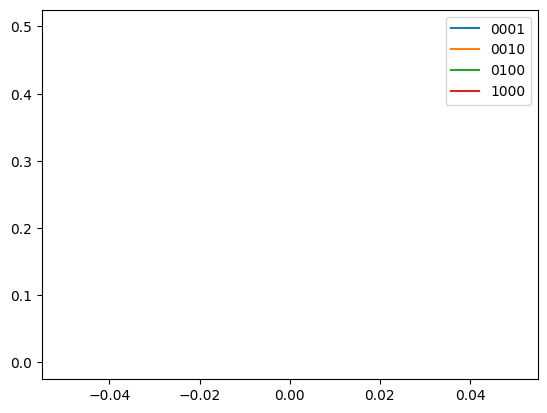

In [119]:
# Evolution block 2

N_steps_block2 = 1
T_block2_list = np.linspace(0, T_duration_list[1], N_steps_block2)

# Store states after every time step

states_block2 = []
states_block2.append(states_block1[-1])

print('Running block 2...')
for t in tqdm(T_block2_list[1:]):
    pauli_gate = PauliEvolutionGate(H_0, t)
    qc.append(pauli_gate, qc.qubits)
    states_block2.append(Statevector(qc))

circ_block2 = qc.copy()


prob_dict_block2 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block2:
    for key in prob_dict_block2.keys():
        prob_dict_block2[key].append(states.probabilities_dict()[key])


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block2_list, prob_dict_block2['0001'], label='0001')
plt.plot(T_block2_list, prob_dict_block2['0010'], label='0010')
plt.plot(T_block2_list, prob_dict_block2['0100'], label='0100')
plt.plot(T_block2_list, prob_dict_block2['1000'], label='1000')
plt.legend()
plt.show()



Running block 3...


0it [00:00, ?it/s]

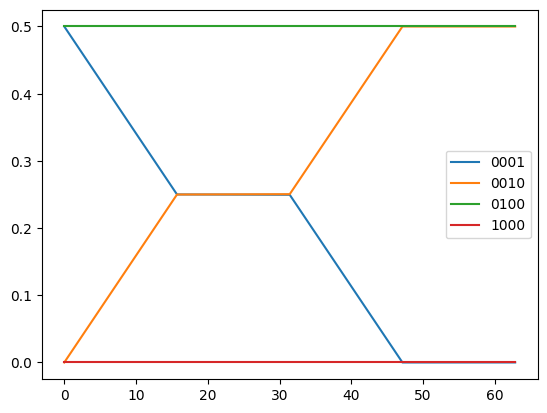

In [120]:
# Evolution block 3

N_steps_block3 = 5
T_block3_list = np.linspace(0, T_duration_list[2], N_steps_block3)
T_EDSR = np.linspace(0, T2, N_steps_block3)

# Create Hamiltonian list for EDSR
H_EDSR_list = []
for t_EDSR in T_EDSR:
    H_EDSR_list.append(H_EDSR(alpha, 0.001, t_EDSR))

# Store states after every time step

states_block3 = []
# states_block3.append(states_block1[-1])


# Append perfectly mixed state between Tu and Bu
# mixed = 1/np.sqrt(2)*(Statevector.from_int(1,16) + Statevector.from_int(4,16))
# states_block3.append(mixed)  


print('Running block 3...')
for i, t in tqdm(enumerate(T_block3_list)):
    pauli_gate = PauliEvolutionGate(H_EDSR_list[i], t)
    qc.append(pauli_gate, qc.qubits)
    states_block3.append(Statevector(qc))


prob_dict_block3 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block3:
    for key in prob_dict_block3.keys():
        prob_dict_block3[key].append(states.probabilities_dict()[key])


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block3_list, prob_dict_block3['0001'], label='0001')
plt.plot(T_block3_list, prob_dict_block3['0010'], label='0010')
plt.plot(T_block3_list, prob_dict_block3['0100'], label='0100')
plt.plot(T_block3_list, prob_dict_block3['1000'], label='1000')
plt.legend()

In [67]:
T_EDSR = np.linspace(0, T2, 100)
# T_EDSR
np.cos(0.001*T_EDSR)

array([1.        , 0.9999998 , 0.99999919, 0.99999819, 0.99999678,
       0.99999497, 0.99999275, 0.99999013, 0.99998711, 0.99998369,
       0.99997986, 0.99997563, 0.999971  , 0.99996596, 0.99996053,
       0.99995469, 0.99994844, 0.9999418 , 0.99993475, 0.9999273 ,
       0.99991944, 0.99991118, 0.99990252, 0.99989346, 0.999884  ,
       0.99987413, 0.99986386, 0.99985318, 0.99984211, 0.99983063,
       0.99981875, 0.99980646, 0.99979377, 0.99978068, 0.99976719,
       0.9997533 , 0.999739  , 0.9997243 , 0.99970919, 0.99969369,
       0.99967778, 0.99966147, 0.99964475, 0.99962763, 0.99961012,
       0.99959219, 0.99957387, 0.99955514, 0.99953601, 0.99951648,
       0.99949654, 0.9994762 , 0.99945546, 0.99943432, 0.99941278,
       0.99939083, 0.99936848, 0.99934572, 0.99932257, 0.99929901,
       0.99927505, 0.99925068, 0.99922592, 0.99920075, 0.99917518,
       0.99914921, 0.99912283, 0.99909605, 0.99906887, 0.99904129,
       0.9990133 , 0.99898491, 0.99895612, 0.99892693, 0.99889

In [180]:
prob_dict_block3['1000']


[1.6465736349752245e-60,
 1.6471486590182238e-60,
 1.6797659342249084e-60,
 1.7412592309464489e-60,
 1.7368532875124163e-60,
 1.544966854506102e-60,
 1.5411686274077984e-60,
 1.5490689397722705e-60,
 1.4299565379694596e-60,
 1.4220562256049872e-60,
 1.1984166140568528e-60,
 1.1017897166760008e-60,
 1.0021242376165061e-60,
 1.0112399826524354e-60,
 1.1109054617119302e-60]

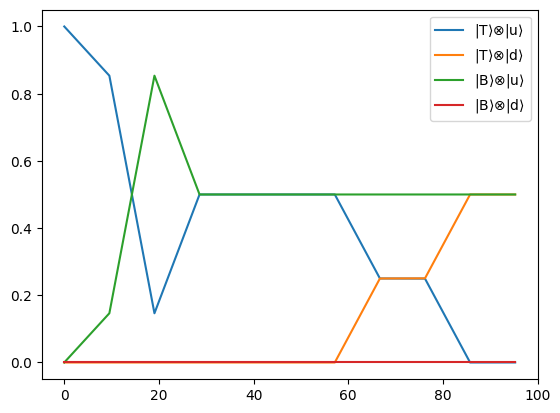

In [121]:
# Patch probabilities together an plot
prob_dict_tot = {'0001':[], '0010':[], '0100':[], '1000':[]}

list_0001 = prob_dict_block1[state_label[0]] + prob_dict_block2[state_label[0]] + prob_dict_block3[state_label[0]]
list_0010 = prob_dict_block1[state_label[1]] + prob_dict_block2[state_label[1]] + prob_dict_block3[state_label[1]]
list_0100 = prob_dict_block1[state_label[2]] + prob_dict_block2[state_label[2]] + prob_dict_block3[state_label[2]]
list_1000 = prob_dict_block1[state_label[3]] + prob_dict_block2[state_label[3]] + prob_dict_block3[state_label[3]]

prob_dict_tot['0001'] = list_0001
prob_dict_tot['0010'] = list_0010
prob_dict_tot['0100'] = list_0100
prob_dict_tot['1000'] = list_1000


T_total_list = np.linspace(0, T_duration_list[0]+T_duration_list[1]+T_duration_list[2], N_steps_block1+N_steps_block2+N_steps_block3)

plt.figure()
plt.plot(T_total_list, prob_dict_tot['0001'], label=state_names[0])
plt.plot(T_total_list, prob_dict_tot['0010'], label=state_names[1])
plt.plot(T_total_list, prob_dict_tot['0100'], label=state_names[2])
plt.plot(T_total_list, prob_dict_tot['1000'], label=state_names[3])

plt.legend()